<a href="https://colab.research.google.com/github/daveking63/Notes_on_Image_Processing_and_Computer_Vision/blob/main/Meta_Segment_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Meta AI Introduces Revolutionary Image Segmentation Model Trained on 1 Billion Masks: Segment Anything - Best DL Model for Image Segmentation.**

Gurami Keretchashvili, Apr 6

https://towardsdatascience.com/meta-ai-introduces-revolutionary-image-segmentation-model-trained-on-1-billion-masks-8f13c86a13a2


Note:
This is a reproduction and summarization of the discussion and code in the article referenced above. The original article can be retrieved by using the above link.

# Introduction
After revolutionary step made by OpenAI’s ChatGPT in NLP, AI progression continues, and Meta AI introduces astonishing progress in computer vision. Meta AI research team introduced the model called Segment Anything Model (SAM) and a dataset of 1 Billion masks on 11 Million images. Segmentation of an image is identifying which image pixels belong to an object.


The proposed project mainly includes three pillars: Task, Model and Data.

**1. Segment Anything Task**

Utilizes a segmentation model based on user's designation of constitutes a segment with respect to the particular image





**2. Segment Anything Model**

The promotable Segment Anything Model (SAM) has three components shown in the figure bellow.
 
A high level of model architecture consists of an image encoder, prompt encoder, and mask decoder. For the image encoder they have used MAE [1] pre-trained model that has Vision Transformer(ViT) [2] architecture. For prompts, they divided them into two types — one type of prompts is sparse such as points, boxes, and text and another type is dense such as masks. The prompt encoder step creates embeddings for each type of prompt. For maps it just maps image embeddings, prompt embeddings, and output tokens to a mask.

**3. Segment Anything Data**

3.1 *Segment Anything Data Engine*

The Meta team tried to select high-quality images to train their model. The team has created a data engine to filter the raw image dataset. Creating a data engine is divided into three stages.

1.	Manual stage: Human professional annotators were involved to label masks on the image manually.
2.	Semi-automatic stage: They trained the model on annotated images and made an inference on the rest of the images. Then, human annotators were asked to label additional unlabeled objects that were not detected by the model or correct segments with low confidence scores.
3.	Fully automatic stage: This stage includes automatic mask generation and automatic filtering stage which tries to leave non-ambiguous masks and keep the masks based on confidence, stability, and size.


3.2 *Segment Anything Dataset*

The Segment Anything Data Engine created a 1 Billion masks dataset (SA-1B) on 11 Million diverse, high resolution (3300x4900 pixels on average) and licensed images. It is worth mentioning that 99.1% of masks were generated automatically, however the quality is so high because they are carefully selected.

**Conclusion — Why is the model evolutionary**

Meta AI team together with other Huge company teams are doing great progress in development of AI. The Segment Anything Model (SAM) has capabilities to power applications in numerous domains that require finding and segmenting any object in any image. For example:

•	SAM could be a component of a large multimodal model that integrated images, text, audio etc.

•	SAM could enable selecting an object AR/VR domain based on a user’s gaze and then “lifting” it into 3D

•	SAM can improve creative applications such as extracting image regions for video editing.

The following is the code implode to demo the various steps of the process. It us a GPU hardware accelerator provided by Colab. Simply use the *Runtime* (drop down menu above) to *Change runtime type* to *GPU*.

In [1]:
from IPython.display import display, HTML
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


In [2]:
# using_colab = True

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ooduenk5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ooduenk5
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=70c8ec7519740f7cfacbf6b57c0e535d0e85c24851fc505dd323bb8dc0ba226c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2uys00e3/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segm

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


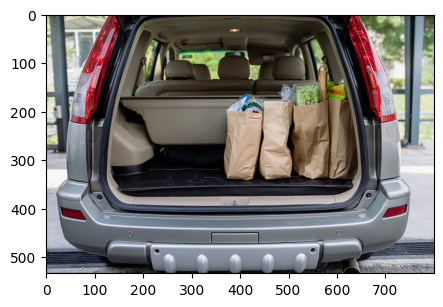

In [4]:
image = cv2.imread('/content/images/groceries.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()


In [5]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)


In [7]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: False


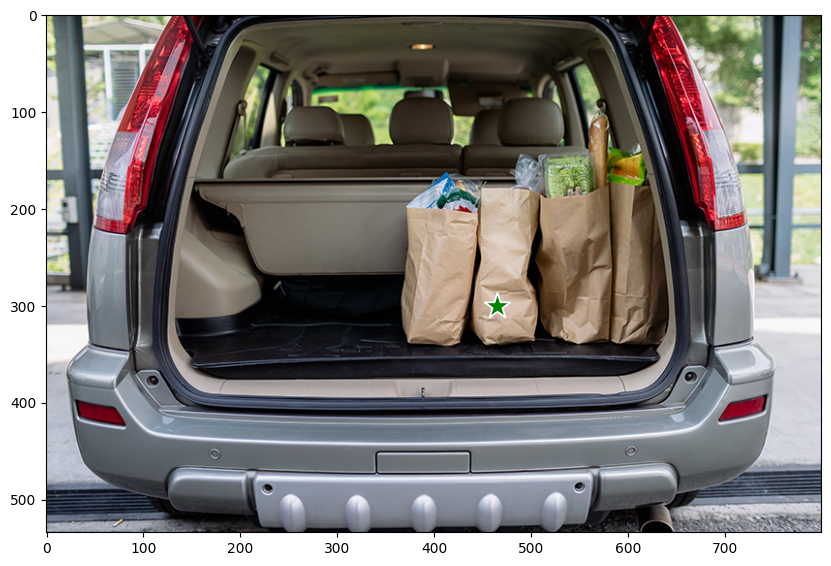

In [7]:
input_point = np.array([[465, 300]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)

show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()


In [8]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print(masks.shape)  # (number_of_masks) x H x W


(3, 534, 800)


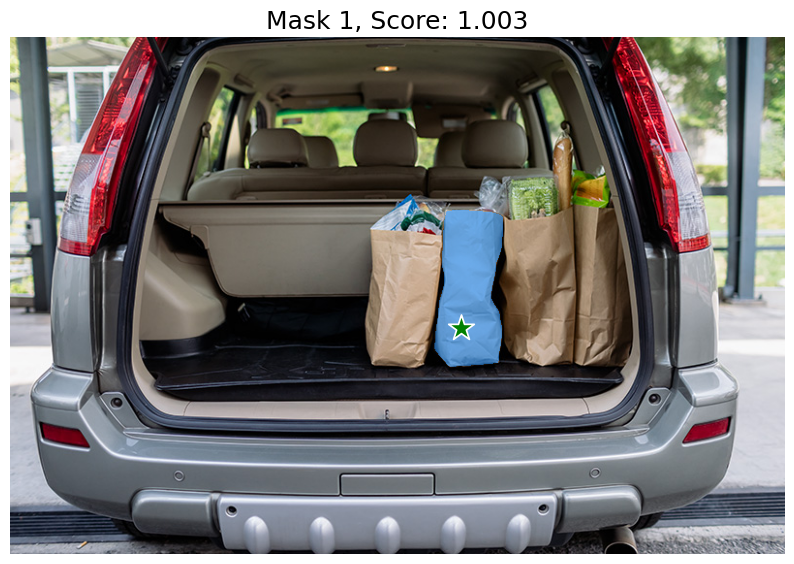

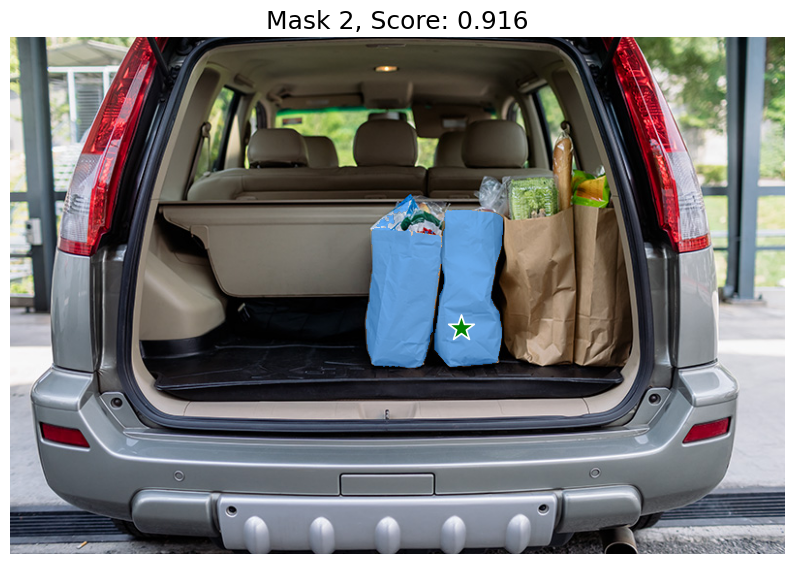

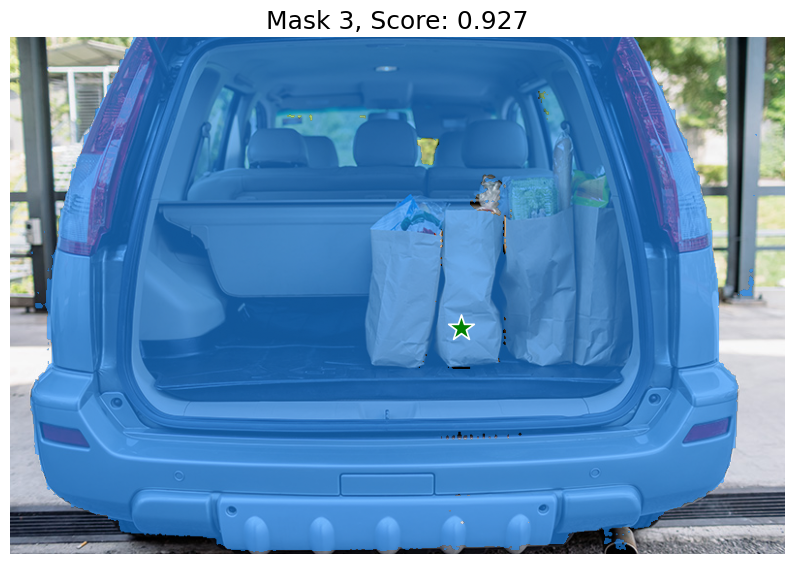

In [9]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 


In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))



In [12]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)
print(len(masks))


137


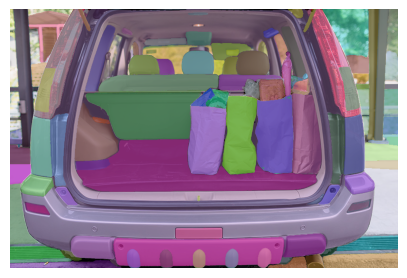

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 
